# Modeling TCLab

Alex Dowling, University of Notre Dame

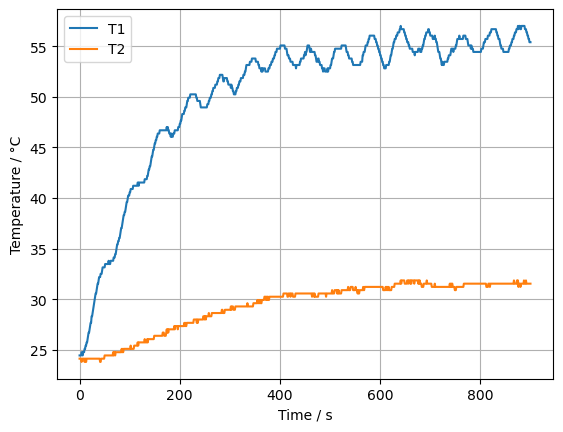

In [97]:
from FoKL import FoKLRoutines
import numpy as np
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt

filename = 'tclab_sine_test.csv'

data = pd.read_csv(filename)
data.plot(x='Time', y=['T1', 'T2'], grid=True, xlabel='Time / s', ylabel='Temperature / °C')
plt.show()

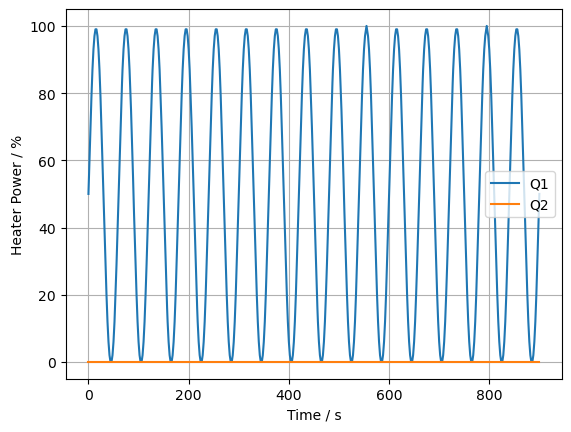

In [98]:
data.plot(x='Time', y=['Q1', 'Q2'], grid=True, xlabel='Time / s', ylabel='Heater Power / %')
plt.show()

We want to train the following mathematical model:

$$
\frac{dT_1}{dt} = f(T_1, Q_1)
$$

where $f(\cdot, \cdot)$ is the GP.

length of time vector:  901
length of derivative vector:  901
length of T1_smooth vector:  901
length of u1 vector:  901


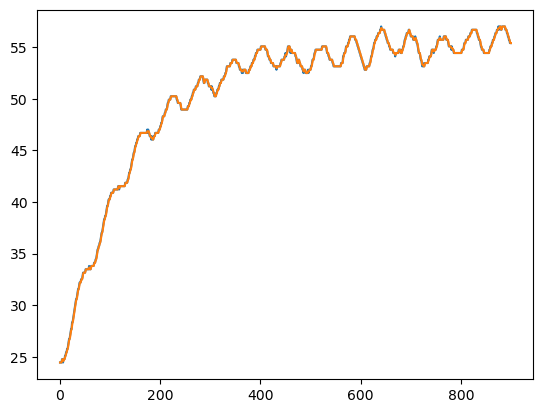

In [99]:
# TODO: look into smoothing the data, or fit smoothing GP to the data
# good chance the derivative is really noisy
# look for "smooth_diff"

# apply rolling mean to smooth the data
window = 2
T1_smooth = data['T1'].rolling(window=window).mean()

# copy the first window values to the beginning of the smoothed data
T1_smooth[0:window] = data['T1'].values[0:window]

# define the time vector
t = data['Time'].values
print("length of time vector: ", len(t))

# calculate the derivative of the smoothed data
dT1dt = np.gradient(T1_smooth, t)
print("length of derivative vector: ", len(dT1dt))

# calculate Tamb
Tamb = T1_smooth[0]

print("length of T1_smooth vector: ", len(T1_smooth))


u1 = data['Q1'].values
print("length of u1 vector: ", len(u1))


plt.plot(t, data['T1'], label='T1 (raw)')
plt.plot(t, T1_smooth, label='T1 (smooth)')
plt.show()


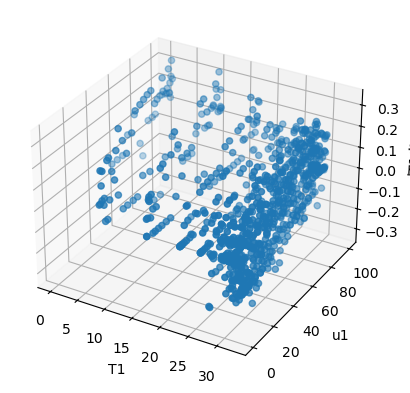

In [100]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(T1, u1, dT1dt)
ax.set_xlabel('T1')
ax.set_ylabel('u1')
ax.set_zlabel('dT1dt')
plt.show()

## Train Model

In [101]:
f = FoKLRoutines.FoKL(kernel=1, UserWarnings=True)
print("\nTraining FoKL model...")
betas, mtx, evs = f.fit([T1_smooth - Tamb, u1], dT1dt, clean=True)
print("Done!")
f.save('attempt1.fokl')


Training FoKL model...
[1, -3012.7343723150216]


/Users/adowling/opt/anaconda3/envs/FoKL/lib/python3.10/site-packages/FoKL/FoKLRoutines.py:292: UserWarning: 'inputs' was transposed. Ignore if more datapoints than input variables, else set 'AutoTranspose=False' to disable.
  warnings.warn("'inputs' was transposed. Ignore if more datapoints than input variables, else set "


[2, -3006.403161663583]
[2, -2995.378906784466]
[3, -2989.2349669036867]
Done!


'attempt1.fokl'

In [102]:
# Plot to visualize dataset and model:
# f.coverage3(plot=True, xlabel='t', xaxis=t, ylabel='y')

In [103]:
dT1dt_pred = f.evaluate([T1_smooth - Tamb, u1], betas, mtx)

/Users/adowling/opt/anaconda3/envs/FoKL/lib/python3.10/site-packages/FoKL/FoKLRoutines.py:742: UserWarning: Provided inputs were converted to numpy array as float64. To change this datatype, call 'clean' first.
  warnings.warn(f"Provided inputs were converted to numpy array as float64. To change this datatype, "
/Users/adowling/opt/anaconda3/envs/FoKL/lib/python3.10/site-packages/FoKL/FoKLRoutines.py:750: UserWarning: Provided inputs were not normalized, so overriding 'clean' to True.
  warnings.warn("Provided inputs were not normalized, so overriding 'clean' to True.")


In [104]:
dt = np.gradient(t)

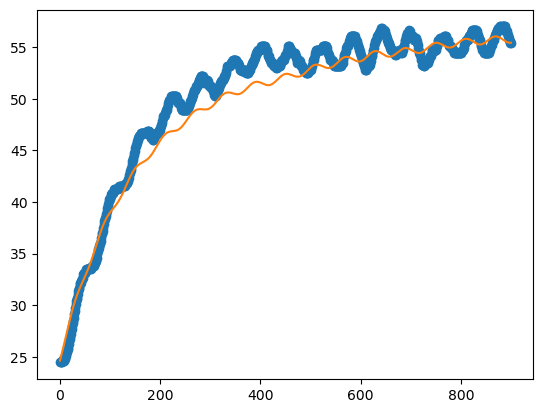

In [105]:
# This is a very simple integration of the derivative to get the prediction
T1_pred = np.cumsum(dT1dt_pred*dt)

plt.plot(t, T1_smooth, label='T1 data', marker='o')
plt.plot(t, T1_pred + Tamb, label='T1 prediction', linestyle='-')
plt.show()